# Library import

In [31]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torch.utils.data as data
from torchvision import datasets, transforms, utils
import torch
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wandb

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

import warnings
warnings.filterwarnings('ignore')

In [32]:
# going to the right directory
print(os.getcwd())
os.chdir("E:\DL_data")
print(os.getcwd())

# defining the directories
root_dir = os.getcwd()
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')
categories = os.listdir(train_dir)

E:\DL_data
E:\DL_data


In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device = {device}")

device = cpu


# Exploration of the dataset

There are 28709 images in the train set for 7 categories
There are 7178 images in the test set for 7 categories


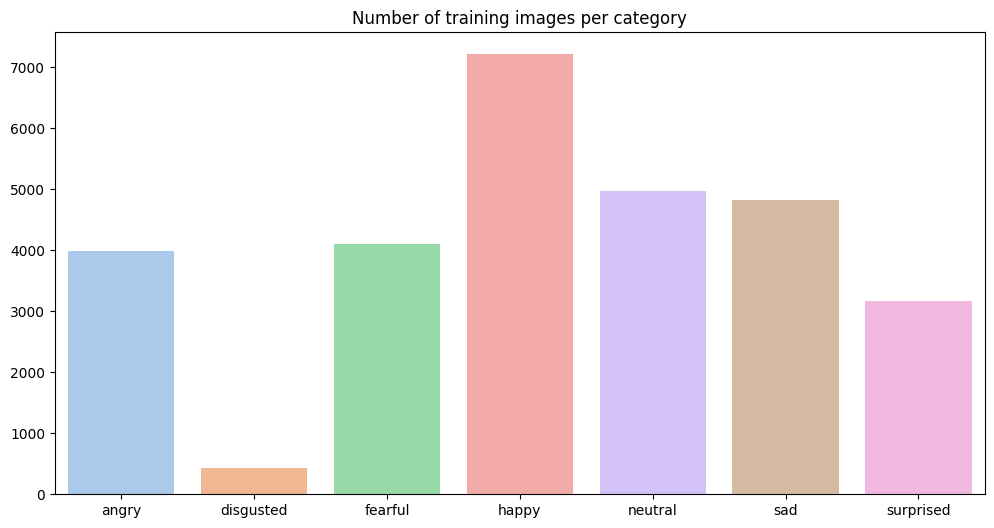

In [34]:
# counting the number of images per category in both train and test
train_counts = []
test_counts = []

for category in categories:
    train_counts.append(len(os.listdir(os.path.join(train_dir, category))))
    test_counts.append(len(os.listdir(os.path.join(test_dir, category))))

print(f"There are {sum(train_counts)} images in the train set for {len(categories)} categories")
print(f"There are {sum(test_counts)} images in the test set for {len(categories)} categories")

plt.figure(figsize=(12, 6))
plt.title('Number of training images per category')
sns.barplot(x=categories, y=train_counts, palette='pastel')
plt.show()

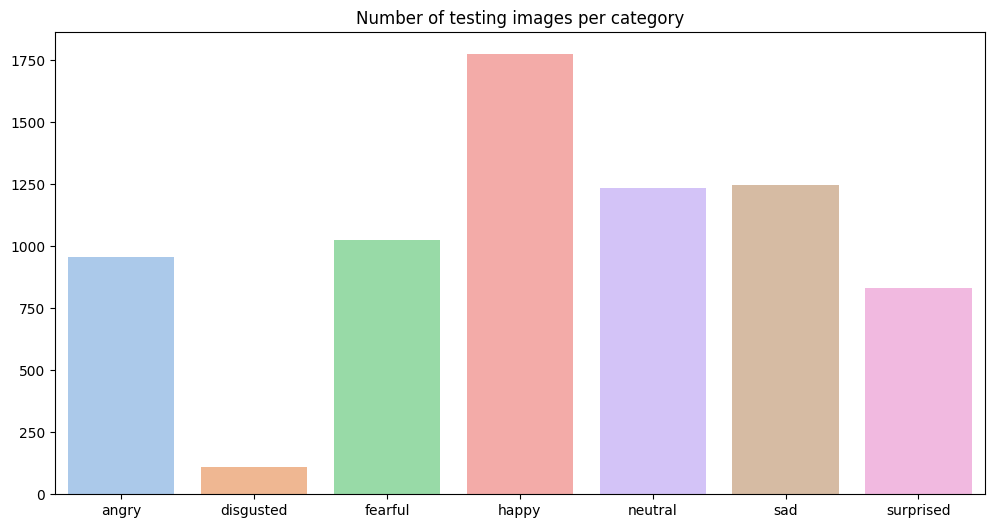

In [35]:
plt.figure(figsize=(12, 6))
plt.title('Number of testing images per category')
sns.barplot(x=categories, y=test_counts, palette='pastel')
plt.show()

We have imbalanced dataset => we will need to deal with that problem.

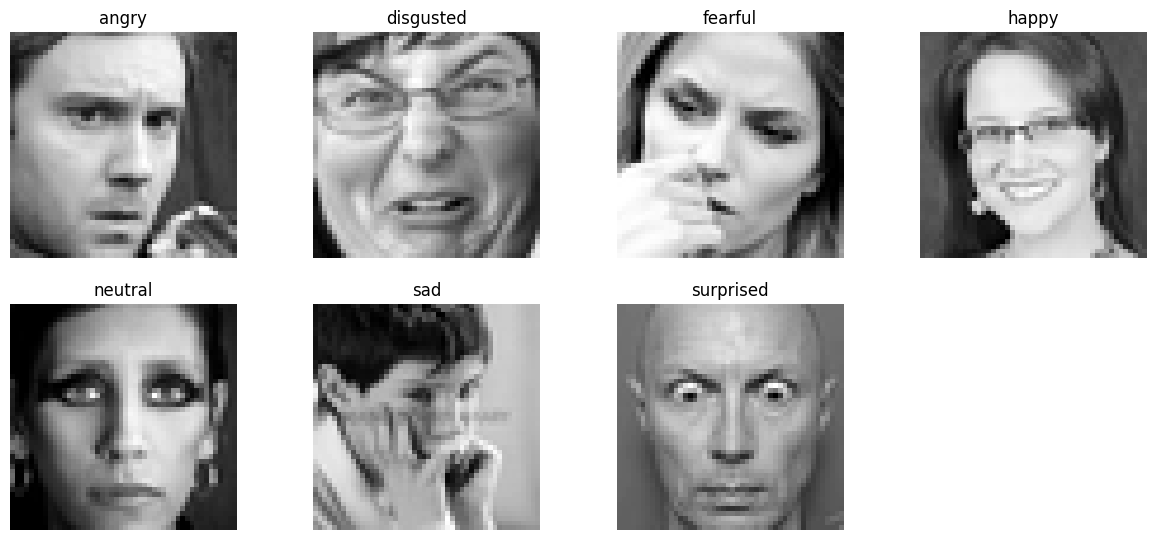

In [36]:
# Give an example of each category
plt.figure(figsize=(15, 10))

for i, category in enumerate(categories):
    cat_path = os.path.join(train_dir, category)
    img_path = os.path.join(cat_path, os.listdir(cat_path)[0])
    img = Image.open(img_path)
    plt.subplot(3, 4, i+1)
    plt.title(category)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# Hyperparameters

In [7]:
model_name = "first_architecture"
eval_every = 5
save_every = 10

# est-ce qu'on pourrait pas faire des batch size différent pour le train et le test/validation ?
# as-tu d'autres idée d'hyperparametre ?
batch_size = 32
learning_rate = 0.001
nb_epochs = 10


# if ask for a key, COPY/PASTE bc0dc5f66039bf86ffba73188a299faed907973c
wandb.init(
    project="deep_learning_project", 
    config = {
        "model": model_name,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "nb_epochs": nb_epochs,
        "eval_every": eval_every,
        "save_every": save_every,
    },
    name=model_name,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jimmy-walraff02 (data-science-project). Use `wandb login --relogin` to force relogin


In [9]:
# wandb.finish()

# LA VARIABLE TRANSFORM_TRAIN EST A MODIFIER AVEC L'ARRAY DE TRANSFORM QUE TU VEUX, LES NAMES SONT AUSSI A MODIFIER
# LE SIMPLE TRANSFORM EST JUSTE POUR RESIZE LES PHOTOS
# LE FOLDER OUTPUT EST ORGANISE COMME CECI => DeepLearning/train ou validation ou test/categories, SAUF QUE DANS LE FOLDER DE BASE Y A PAS DE VALIDATION => SI VALIDATION DANS INPUT C'EST TRAIN, IL FAUT QUE TU CREES CE DIRECTORY AVANT DE RUN
# PUIS APRES J'ITERE DANS LES DIFFERENTS FOLDER DE L'INPUT FOLDER (CATEGORY)
# PUIS J'ITERE SUR LES FILES DANS LE FOLDER DE L'EMOTION
# PUIS J'ITERE SUR LES TRANSFORMS ET SAVE LES IMAGES TRANSFORMEE
# IL FAUT DONC CHANGER LE DATASET POUR QUE CA SOIT COHERENT (JUSTE ALLER CHERCHER L'IMAGE PATH DANS LE INIT, PUIS DANS LE GET ITEM OUVRIR L'IMAGE)

In [46]:
output_dir = "E:\DeepLearning_data_test"

transform_train = [transforms.Compose([
            transforms.RandomHorizontalFlip(1),
            transforms.ToTensor()
        ]), transforms.Compose([
            transforms.RandomRotation(10),
            transforms.ToTensor()
        ])]

transforms_train_name = ["RandomHorizontalFlip", "Rotation"]

simple_transform = [transforms.Compose([
            transforms.Resize((300, 300)),
            transforms.ToTensor()
        ])]

categories = ["disgusted"]

for folder in ["train", "validation", "test"]:
    input = folder
    if folder == "validation":
        input = "train"

    print(f"Processing {folder} folder")        
    for category in categories:
        input_folder = os.path.join(root_dir, input, category)
        output_folder = os.path.join(output_dir, folder, category)

        array = os.listdir(input_folder)

        if folder == "train":
            array = array[:int(len(array)*0.8)]
        elif folder == "validation":
            array = array[int(len(array)*0.8):]

        print(f"Processing {category} category")
        for i, filename in enumerate(array):
            # print(f"filename = {filename}")
            path = os.path.join(input_folder, filename)
            # print(f"path = {path}")
            image = Image.open(path)

            if folder == "train":
                transform = transform_train
            else:
                transform = simple_transform

            if i % 500 == 0:
                print(f"Processing image {i}")
            for i, transf in enumerate(transform):
                image_transformed = transf(image)
                
                if folder == "train":
                    name_of_the_image = f"{filename}_{transforms_train_name[i]}.png"
                else:
                    name_of_the_image = f"{filename}.png"

                save_image(image_transformed, os.path.join(output_folder, name_of_the_image))

Processing train folder
Processing disgusted category
Processing image 0
Processing validation folder
Processing disgusted category
Processing image 0
Processing test folder
Processing disgusted category
Processing image 0


# Dataset class

# JE PENSE QUE DU COUP LE DATASET EST PLUS COHERENT POUR LE 2E ET PAS LE PREMIER

In [9]:
class EmotionDataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None, val=False):
        self.root_dir = root_dir # Directory where we can find train and test folder
        self.transform = transform
        self.categories = {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3,
                           'neutral': 4, 'sad': 5, 'surprised': 6} # Defines the category in order to keep track of the label
        self.images = [] # store the images
        self.labels = [] # store the label

        # Determine train or test directory
        data_dir = os.path.join(self.root_dir, mode)

        # Iterate over each category
        for category_name, category_id in self.categories.items():
            category_dir = os.path.join(data_dir, category_name)
            if not os.path.isdir(category_dir):
                raise FileNotFoundError(f"Directory {category_dir} not found.")
            
            array = os.listdir(category_dir)
            
            # Split the dataset into train and validation set, 20% of each class in the validation set
            if val and (mode == 'train'):
                array = array[int(len(array)*0.8):]
            elif not val and (mode == 'train'):
                array = array[:int(len(array)*0.8)]


            # Iterate over images in the category directory
            for filename in array:
                image_path = os.path.join(category_dir, filename)

                image = Image.open(image_path)

                if image.mode != 'L':
                    image = image.convert('L')

                # looping over the different transformation to augment the dataset
                if self.transform:
                    for transf in self.transform:
                        image_transf = transf(image)
                        self.images.append(image_transf)
                        self.labels.append(category_id)
                else:
                    self.images.append(image)
                    self.labels.append(category_id)

    def __len__(self):
        # return the number of the images, depending on the self.mode it will correspond to train/test
        return len(self.images)

    def __getitem__(self, idx):
        # retrieve image and label for idx
        image = self.images[idx]
        label = self.labels[idx]

        return image, label

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None, val=False):
        self.root_dir = root_dir # Directory where we can find train and test folder
        self.transform = transform
        self.categories = {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3,
                           'neutral': 4, 'sad': 5, 'surprised': 6} # Defines the category in order to keep track of the label
        self.images = [] # store the images path
        self.labels = [] # store the label

        # Determine train or test directory
        data_dir = os.path.join(self.root_dir, mode)

        # Iterate over each category
        for category_name, category_id in self.categories.items():
            category_dir = os.path.join(data_dir, category_name)
            if not os.path.isdir(category_dir):
                raise FileNotFoundError(f"Directory {category_dir} not found.")

            # Iterate over images in the category directory
            for filename in os.listdir(category_dir):
                image_path = os.path.join(category_dir, filename)
                self.images.append(image_path)
                self.labels.append(category_id)

    def __len__(self):
        # return the number of the images, depending on the self.mode it will correspond to train/test
        return len(self.images)

    def __getitem__(self, idx):
        # retrieve image and label for idx
        image_path = self.images[idx]
        label = self.labels[idx]

        # open image
        image = Image.open(image_path)

        # if not in gray mode, convert it
        if image.mode != 'L':
            image = image.convert('L')

        return image, label

In [10]:
# since i want to do data augmentation, i want to have a probability of 1 to flip the image
transform_horizontalFlip = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(1),
    transforms.ToTensor()
])

transform_verticalFlip = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomVerticalFlip(1),
    transforms.ToTensor()
])

transform_bothFlip = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(1),
    transforms.RandomVerticalFlip(1),
    transforms.ToTensor()
])

transforms_noFlip = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])

# à voir si on garde celle-ci, elle rajoute des bords noirs dans l'image
transforms_rotation = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomRotation(45),
    transforms.ToTensor()
])

transforms_elastic = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ElasticTransform(),
    transforms.ToTensor()
])

train_transforms = [transform_horizontalFlip, transform_verticalFlip, transform_bothFlip, transforms_noFlip, transforms_rotation, transforms_elastic]

# je ne veux pas que le test/validation set soit modifié https://stackoverflow.com/questions/48029542/data-augmentation-in-test-validation-set/48031128#48031128?newreg=82e31bf4a3714b2185e0fff3eaf3cd04
simple_transform = [transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])]

# IL FAUDRAIT MODIFIER LE MODE DU VALIDATION SET EN "VALIDATION" CAR LE FOLDER EST MTN COMPOSE DE TRAIN/VALIDATION/TEST

In [11]:
# Let's try to instantiate a dataset and a dataloader
train_set = EmotionDataset(root_dir, mode='train', transform=simple_transform)
validation_set = EmotionDataset(root_dir, mode='train', transform=simple_transform, val=True)
test_set = EmotionDataset(root_dir, mode='test', transform=simple_transform)

train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_loader = data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

# 21m14s de run
print(f"length of train_loader {len(train_loader)}, length of validation_loader {len(validation_loader)}, length of test_loader {len(test_loader)}")

UnidentifiedImageError: cannot identify image file 'E:\\DeepLearning_data\\train\\angry\\im0.png'

<class 'torch.Tensor'>


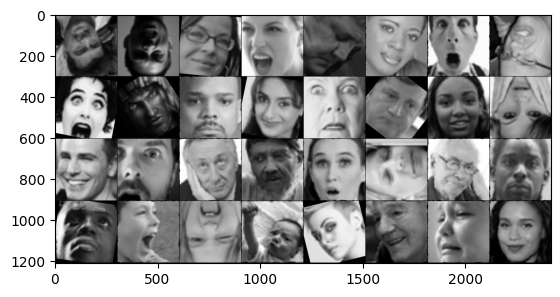

angry angry happy angry sad neutral surprised angry angry angry neutral happy fearful sad happy surprised happy surprised angry neutral surprised neutral neutral neutral neutral happy disgusted angry neutral happy sad happy


In [64]:
# comes from hw2
def show_images(img):
    plt.imshow(transforms.functional.to_pil_image(img), cmap='gray')
    plt.show()

# show the images from a batch
images, labels = next(iter(train_loader))
print(type(images))
show_images(utils.make_grid(images))
print(*[categories[l] for l in labels])

# Class Weights

In [11]:
# source of the formula https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
weights = []
n_sample = sum(train_counts)
n_category = len(categories)

for i, n_sample_i in enumerate(train_counts):
    weights.append(n_sample/(n_category*n_sample_i))

weights = torch.tensor(weights, dtype=torch.float)
weights

tensor([1.0266, 9.4066, 1.0010, 0.5684, 0.8260, 0.8491, 1.2934])

# Model

In [12]:
class ConvNet(nn.Module):
    def __init__(self):
        # basic architecture from slide 35/59 lecture 6 of deep learning course
        # INPUT → [[CONV → ReLU]*N → POOL?]*M → [FC → ReLU]*K → FC
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64*73*73, 128) # aucune idée de si c'est juste (merci copilot, apres avec un run, je saurais change ceci) (pour le 64*73*73)
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64*73*73) # pareil ici (pour le 64*73*73)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
convnet = ConvNet()
convnet.train()

print(f"convnet architecture: \n{convnet}")

# from https://saturncloud.io/blog/check-the-total-number-of-parameters-in-a-pytorch-model/#:~:text=To%20check%20the%20number%20of%20parameters%20in%20a%20PyTorch%20model,its%20total%20number%20of%20elements
print(f"\n numbers of parameters: {sum(p.numel() for p in convnet.parameters())}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(convnet.parameters(), lr=learning_rate)

convnet architecture: 
ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=341056, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)

 numbers of parameters: 43675015


# Training

Faut-il rajouter plus de truc dans wandb.log ?

In [16]:
def train_cnn(num_epochs):
    train_avg_loss = []
    validation_avg_loss = []
    validation_accuracy = []

    # transfer cnn to GPU (in-place)
    convnet.to(device)

    print("Entering epoch loops.....")
    for i in range(num_epochs):
        train_losses = []
        validation_losses = []
        recall_scores = []
        precision_scores = []
        f1_scores = []

        print("Entering train loop....")
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            pred = convnet(x)
            loss = criterion(pred, y)

            wandb.log({
                "epoch": i, 
                "train_loss": loss
            })

            train_losses.append(loss.detach())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_avg_loss.append(np.array(train_losses).mean())

        # à modifier en fonction du nb d'epoch qu'on met
        if i % eval_every == 0:
            print("Entering validation.....")
            with torch.no_grad():
                correct = 0

                # list because we wan't evaluate on each batch (some labels might not be in a batch)
                true_labels = torch.tensor([])
                pred_labels = torch.tensor([])

                for x, y in validation_loader:
                    x = x.to(device)
                    y = y.to(device)

                    pred = convnet(x)
                    loss = criterion(pred, y)

                    wandb.log({
                        "epoch": i, 
                        "validation_loss": loss
                    })

                    validation_losses.append(loss.detach())

                    y_pred = pred.argmax(dim=-1)
                    correct = correct + (y_pred == y).sum()

                    true_labels = torch.cat((true_labels, y.cpu()))
                    pred_labels = torch.cat((pred_labels, y_pred.cpu()))

                recall_scores.append(recall_score(true_labels, pred_labels))
                precision_scores.append(precision_score(true_labels, pred_labels))
                f1_scores.append(f1_score(true_labels, pred_labels))

                validation_avg_loss.append(np.array(validation_losses).mean())
                accuracy = correct / len(validation_set)
                validation_accuracy.append(accuracy)

                print(f"Epoch {i}")
                print("************************************")
                print()

            if i % save_every == 0:
                torch.save(convnet.state_dict(), f"model_intermediate/convnet_{i}.pt")

    train_avg_loss = np.array(train_avg_loss)
    validation_avg_loss = np.array(validation_avg_loss)

    torch.save(convnet.state_dict(), f"model_finished/convnet__finished_{num_epochs}.pt")

    return train_avg_loss, validation_avg_loss, validation_accuracy, recall_scores, precision_scores, f1_scores

In [17]:
train_avg_loss, validation_avg_loss, validation_accuracy, recall_scores, precision_scores, f1_scores = train_cnn(nb_epochs)

Entering epoch loops.....
Entering train loop....


KeyboardInterrupt: 